# Electric Overview
This notebook looks through the electric data we have available.

From Darren Bevill:
The meters represented under ESB are a collection of main feeds and sub-feeds.  You will see one identified as “vMain” which is our designation for a virtual summation of the two main feeds (MA & MB) that enter the building representing the total building load.  The ones designated as “WCM” are power meters for the chillers in the building.  The rest are just sub feeds that feed different panels throughout the building.

This is good because we can break data up by the sub feeds throughout the building and compare it to the overall impact it has on energy consumption for the building.

For this data we need to:
- Identify the locations of each of the sub-feeds. May be able to do this in Metasys
- From the sub feeds, determine which ones are important and relevant for our purposes
- Create some cluster models relating external parameters to the electricity overview
- Try to apply these clusters to develop a "schedule"

We might be limited by the granularity of this data - hopefully we can break the subfeeds up into general areas like "makerspace", "clean room", etc.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [3]:
electricity_data = pd.read_csv('Data/ESB_Electric.csv', index_col='time', parse_dates=True)
electricity_data.sort_index(axis='columns', inplace=True)

# Correlation Coefficients
First test how the fields relate to each other

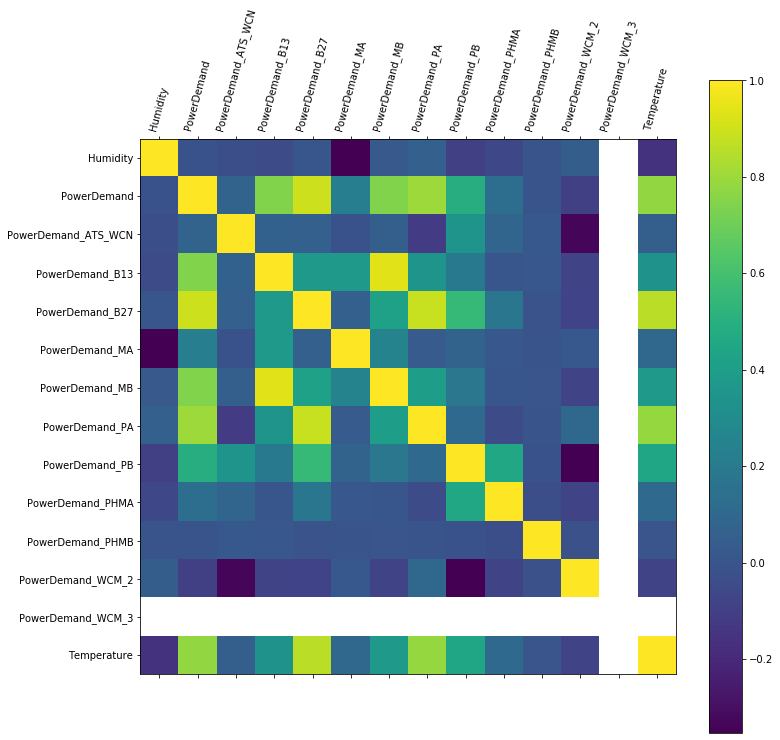

In [4]:
fig, ax = plt.subplots(figsize=(12,12))
correlations = electricity_data.corr()
plt.matshow(correlations,fignum=0)
plt.colorbar()
plt.xticks(np.arange(len(electricity_data.columns)),electricity_data.columns, rotation=75)
plt.yticks(np.arange(len(electricity_data.columns)),electricity_data.columns);

In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(correlations))

Top Absolute Correlations
PowerDemand_B13  PowerDemand_MB     0.989493
PowerDemand_B27  Temperature        0.977382
PowerDemand      PowerDemand_B27    0.927224
PowerDemand_B27  PowerDemand_PA     0.922286
PowerDemand      Temperature        0.911363
dtype: float64


In [6]:
correlations['Temperature']['PowerDemand']

0.7804091549827531

Break the data into seasons and feature scale

In [12]:
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(electricity_data)
scaled_df = pd.DataFrame(scaled_df, columns=electricity_data.columns, index=electricity_data.index)

spring = scaled_df['2019-03':'2019-05']
summer = scaled_df['2019-06':'2019-08']
fall = scaled_df['2019-09':'2019-11']
winter = scaled_df['2019-01':'2019-02'].append(electricity_data['2019-12'])
seasons = [spring,summer,fall,winter]

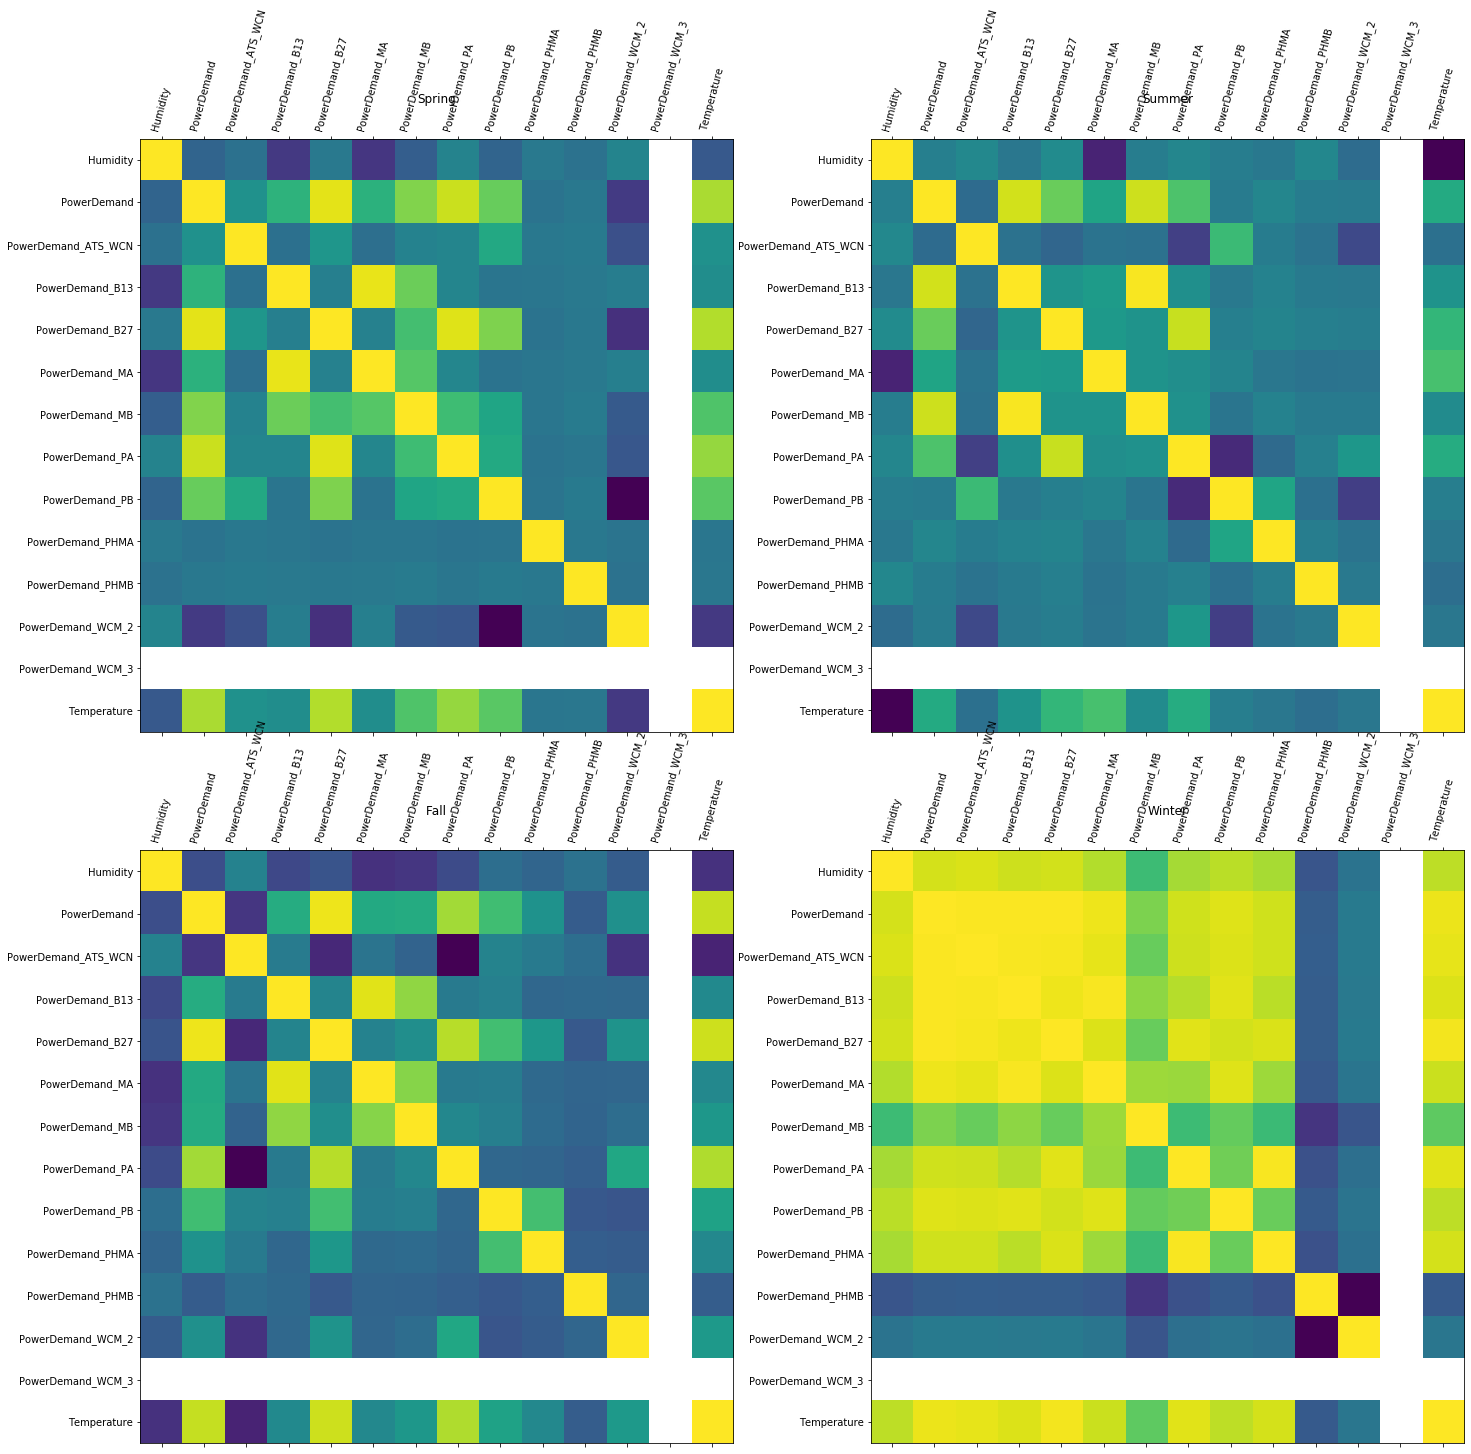

In [13]:
fig, ax = plt.subplots(2,2,figsize=(24,24))
season_corr = []
for season in seasons:
    season_corr.append(season.corr())
ax[0,0].matshow(season_corr[0])
ax[0,0].set_title('Spring')
ax[0,1].matshow(season_corr[1])
ax[0,1].set_title('Summer')
ax[1,0].matshow(season_corr[2])
ax[1,0].set_title('Fall')
ax[1,1].matshow(season_corr[3])
ax[1,1].set_title('Winter')
# plt.colorbar()
plt.setp(ax,
         xticks=np.arange(len(electricity_data.columns)),
         xticklabels=electricity_data.columns,
         yticks= np.arange(len(electricity_data.columns)),
         yticklabels=electricity_data.columns,
        );
for axis in ax.ravel():
    axis.tick_params(axis='x', labelrotation=75)

In [71]:
for axis in ax.ravel():
    print(type(axis))

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


In [10]:
scaled_df

,Humidity,PowerDemand,PowerDemand_ATS_WCN,PowerDemand_B13,PowerDemand_B27,PowerDemand_MA,PowerDemand_MB,PowerDemand_PA,PowerDemand_PB,PowerDemand_PHMA,PowerDemand_PHMB,PowerDemand_WCM_2,PowerDemand_WCM_3,Temperature
0,0.902088,0.384275,0.999878,0.376312,0.390999,0.523156,0.522334,0.246625,0.369106,0.000198,0.000000,0.000107,0.0,0.577644
1,0.894523,0.364881,0.999878,0.388273,0.343992,0.519077,0.554867,0.209050,0.338058,0.000198,0.000000,0.999893,0.0,0.574138
2,0.891965,0.382140,0.999878,0.402013,0.364340,0.517171,0.550714,0.215482,0.366013,0.000198,0.000000,0.000122,0.0,0.574138
3,0.888718,0.383724,0.999893,0.394741,0.373726,0.520567,0.550525,0.224635,0.369051,0.000198,0.000000,0.000122,0.0,0.572412
4,0.888718,0.366797,0.999878,0.383132,0.352125,0.512458,0.525363,0.201655,0.364635,0.000198,0.999939,0.999908,0.0,0.572412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103910,0.439282,0.385713,0.999878,0.413052,0.361332,0.532530,0.494299,0.327812,0.187230,0.000381,0.000031,0.999893,0.0,0.442926
103911,0.439282,0.389775,0.999878,0.400166,0.380324,0.511237,0.495087,0.332252,0.217364,0.000381,0.999985,0.999893,0.0,0.442926
103912,0.439439,0.394060,0.999893,0.397810,0.390455,0.541129,0.479204,0.343935,0.218611,0.000381,0.000031,0.999893,0.0,0.442916
103913,0.439439,0.382915,0.999878,0.399807,0.367741,0.487479,0.464431,0.330470,0.192377,0.000381,0.000031,0.999893,0.0,0.442916
